<hr/>

# imports

In [ ]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [76]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn
import imblearn

In [77]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [78]:

def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [79]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [80]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse

    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    data['sender_labels_encoded'] = data['sender_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data['receiver_labels_encoded'] = data['receiver_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data["game_score_delta"] = data['game_score_delta'].astype(float)
    return data

In [81]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, skip_evaluation: bool = False) -> tuple[float, float]:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        skip_evaluation: bool
            skip the model.evaluate() function
    """
    def find_best_threshold(y_true, y_probs):
        best_threshold = 0.5
        best_f1 = 0.0

        # Iterate over a range of thresholds (e.g., 0.0 to 1.0)
        for threshold in np.arange(0.0, 1.0, 0.01):
            # Convert probabilities to binary predictions based on the current threshold
            y_pred = (y_probs > threshold).astype(int)

            # Calculate the F1 score
            f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')

            # If this F1 score is better than the best so far, update the best threshold and F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        return best_threshold, best_f1

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['sender_output_auc'], label='sender_output_auc', color="tan", linestyle="dashed")
    plt.plot(history.history['val_sender_output_auc'], label = 'val_sender_output_auc', color="darkorange")
    plt.plot(history.history['receiver_output_auc_1'], label='receiver_output_auc', color="cornflowerblue" , linestyle="dashed")
    plt.plot(history.history['val_receiver_output_auc_1'], label = 'val_receiver_output_auc', color="darkblue")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.03])
    plt.legend(loc='lower right')
    plt.show()

    if not skip_evaluation:
        print(f"{'='*10} Test Evaluation {'='*10}")
        model.evaluate(test_ds, test_target, verbose=2)
        # print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
        print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)

    # Find the best threshold for sender
    best_threshold_sender, best_f1_sender = find_best_threshold(test_target[0], y_pred[0])
    print("Best Threshold for Sender:", best_threshold_sender, "with F1 Score:", best_f1_sender)

    # Find the best threshold for receiver
    best_threshold_receiver, best_f1_receiver = find_best_threshold(test_target[1], y_pred[1])
    print("Best Threshold for Receiver:", best_threshold_receiver, "with F1 Score:", best_f1_receiver)

      # Convert probabilities to binary predictions
    y_pred_sender = (y_pred[0] > best_threshold_sender).astype(int).reshape(-1)
    y_pred_receiver = (y_pred[1] > best_threshold_receiver).astype(int).reshape(-1)

    print()
    print(f"{'-'*10} Sender Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[0], y_pred_sender, target_names=["True", "False"], zero_division=0))
    print(f"{'-'*10} Receiver Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[1], y_pred_receiver, target_names=["True", "False"], zero_division=0))

    return best_threshold_sender, best_threshold_receiver

In [82]:

def Tokenize(tokenizer, df: pd.DataFrame, sequence_len: int = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

In [83]:
def PredictionGridPeek(pred: list, df: pd.DataFrame, target_labels: list, who: str) -> pd.DataFrame:
    table = {
        "prediction": [],
        "target": [],
        "message": [],
        "context": []
    }
    for match in [True, False]:
        bool_stmt = pred == df[f'{who}_labels_encoded'] if match else pred != df[f'{who}_labels_encoded']
        visited = []
        for i in range(0, len(pred[bool_stmt])):
            row = df[bool_stmt].iloc[i,:]
            pred_label = target_labels[pred[bool_stmt][i]]
            if (pred_label, row[f'{who}_labels']) not in visited:
                table["prediction"].append(pred_label)
                table["target"].append(row[f'{who}_labels'])
                table['message'].append(row['messages'])
                table['context'].append(row['previous_message'])
                visited.append((pred_label, row[f'{who}_labels']))
                if len(visited) >= len(target_labels):
                    break
    return pd.DataFrame(table)

<hr/>

# data explortion

just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

## NOANNOTATION

In [84]:
# train_df = (parse_jsonl("./data/train.jsonl"))
# test_df = (parse_jsonl("./data/test.jsonl"))
# validation_df = (parse_jsonl("./data/validation.jsonl"))

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Colab Notebooks/w266 Final Project'

train_df = (parse_jsonl(f"{folder_path}/data/train.jsonl"))
test_df = (parse_jsonl(f"{folder_path}/data/test.jsonl"))
validation_df = (parse_jsonl(f"{folder_path}/data/validation.jsonl"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:

train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0.0,1,0,It seems like there are a lot of ways that cou...,straightforward,0,2


# NOANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value

In [86]:
print("NOANNOTATION percentage in:")
print(f'train = {(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index)) * 100:.2f}%')
print(f'test = {(len(test_df[test_df["receiver_labels"] == "NOANNOTATION"].index) /  len(test_df.index)) * 100:.2f}%')
print(f'validation = {(len(validation_df[validation_df["receiver_labels"] == "NOANNOTATION"].index) /  len(validation_df.index)) * 100:.2f}%')

NOANNOTATION percentage in:
train = 8.43%
test = 9.70%
validation = 9.39%


The percentages are low in each dataset and "NOANNOTATION" does not provide any meaningful value so we will remove it to keep the results a boolean value `True` or `False`.

In [87]:
train_df = train_df[train_df["receiver_labels"] != "NOANNOTATION"]
test_df = test_df[test_df['receiver_labels'] != "NOANNOTATION"]
validation_df = validation_df[validation_df['receiver_labels'] != "NOANNOTATION"]

# Unique Words

In [88]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 11
just: 1146
the: 6037
person: 28
i: 8250
want: 779
to: 10653
speak: 17
with.: 34
have: 1944
a: 4399
somewhat: 15
crazy: 15
idea: 89
that: 3414
i’ve: 139
always: 75
wanted: 136
try: 284
with: 2364
i/g,: 1
but: 2086
never: 96
actually: 195
convinced: 11
other: 271
guy: 29
it.: 244
and,: 34
what’s: 73
worse,: 3


In [89]:
len(unique_words)

14991

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

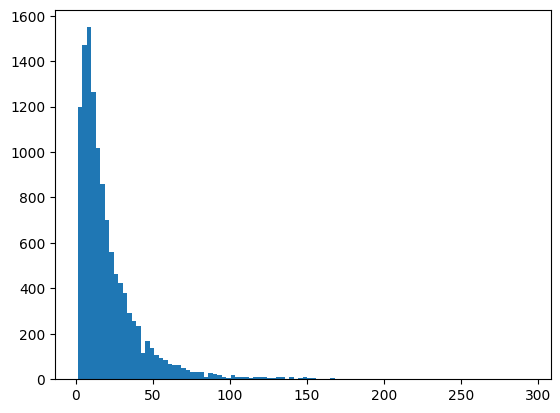

In [90]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [91]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,12025
1,Average words per message,20
2,Unique word count,14991
3,Actual Lie count,545
4,Actual Truth count,11480


# Label count

In [92]:
train_df['label'].value_counts()

straightforward    10979
cassandra            501
deceive              480
caught                65
Name: label, dtype: int64

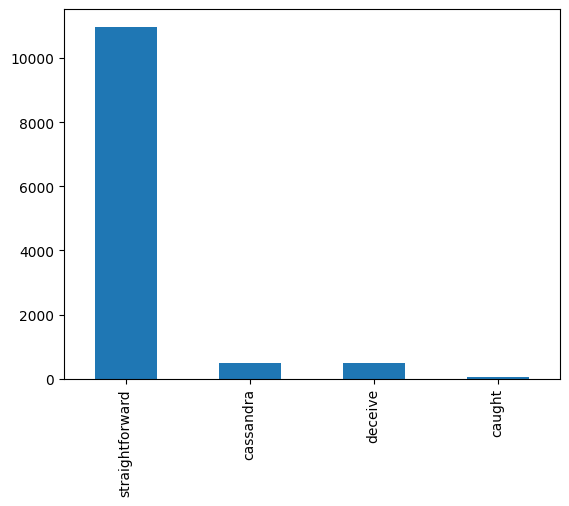

In [93]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [94]:
train_df['label'].value_counts(normalize=True)

straightforward    0.913015
cassandra          0.041663
deceive            0.039917
caught             0.005405
Name: label, dtype: float64

<hr/>

# Constants

In [95]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)
EMBEDDING_OUTPUT_SIZE = 124
LSTM_SIZE = 64
DROPOUT_RATE = 0.2
HIDDEN_LAYER_SIZE = 64
LEARNING_RATE = 0.001

CLASS_LABELS = ["True", "False"]

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
# smote = imblearn.over_sampling.SMOTE()

# train_encoded_padded, y_train = smote.fit_resample(train_tokenized_padded, train_df['label_encoded'])
# train_prev_encoded_padded, y_train = smote.fit_resample(train_prev_tokenized_padded, train_df['label_encoded'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

<hr/>

# Naive Neural Network

In [96]:
def create_naive_model(
        vocab_size: int = VOCAB_SIZE,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        sequence_length: int = MAX_SEQUENCE_LEN,
        hidden_size: int = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_size, activation="relu")
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(naive_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(naive_output)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

In [97]:
naive_model = create_naive_model()
naive_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 flatten_1 (Flatten)         (None, 36456)                0         ['embedding_20[0][0]']        
                                                                                                  
 dense_14 (Dense)            (None, 64)                   2333248   ['flatten_1[0][0]']           
                                                                                           

In [98]:
naive_history = naive_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 22s 53ms/step - loss: 0.3804 - sender_output_loss: 0.1846 - receiver_output_loss: 0.1958 - sender_output_auc: 0.5992 - receiver_output_auc_1: 0.5316 - val_loss: 0.3226 - val_sender_output_loss: 0.1603 - val_receiver_output_loss: 0.1623 - val_sender_output_auc: 0.6705 - val_receiver_output_auc_1: 0.5190
Epoch 2/10
376/376 [==============================] - 6s 15ms/step - loss: 0.3004 - sender_output_loss: 0.1457 - receiver_output_loss: 0.1547 - sender_output_auc: 0.8094 - receiver_output_auc_1: 0.8196 - val_loss: 0.3449 - val_sender_output_loss: 0.1719 - val_receiver_output_loss: 0.1729 - val_sender_output_auc: 0.5856 - val_receiver_output_auc_1: 0.5132
Epoch 3/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1544 - sender_output_loss: 0.0789 - receiver_output_loss: 0.0755 - sender_output_auc: 0.9639 - receiver_output_auc_1: 0.9730 - val_loss: 0.4370 - val_sender_output_loss: 0.2297 - val_receiver_output_loss: 0.20

========== Model Accuracy ==========


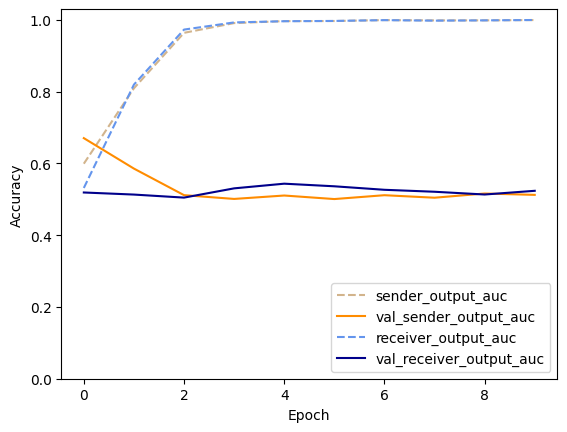

========== Test Evaluation ==========
78/78 - 0s - loss: 1.8151 - sender_output_loss: 0.9779 - receiver_output_loss: 0.8372 - sender_output_auc: 0.5058 - receiver_output_auc_1: 0.5274 - 266ms/epoch - 3ms/step

========== Test Metrics ==========
78/78 [==============================] - 0s 2ms/step
Best Threshold for Sender: 0.05 with F1 Score: 0.5067036523347203
Best Threshold for Receiver: 0.01 with F1 Score: 0.5222394708423326

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.96      0.94      2268
       False       0.11      0.06      0.08       207

    accuracy                           0.88      2475
   macro avg       0.51      0.51      0.51      2475
weighted avg       0.85      0.88      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.94      0.94      2310
       False       0.11      0.10      0.11       165

  

In [99]:
EvaluateModel(naive_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_history);

# Naive LSTM

In [100]:
def create_naive_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-4,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_lstm_ouput = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(naive_lstm_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(naive_lstm_ouput)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

In [101]:
naive_lstm_model = create_naive_lstm_model()
naive_lstm_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 lstm_20 (LSTM)              (None, 64)                   48384     ['embedding_21[0][0]']        
                                                                                                  
 dense_15 (Dense)            (None, 64)                   4160      ['lstm_20[0][0]']             
                                                                                           

In [102]:
naive_lstm_history = naive_lstm_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 25s 58ms/step - loss: 0.4723 - sender_output_loss: 0.2304 - receiver_output_loss: 0.2419 - sender_output_auc: 0.5689 - receiver_output_auc_1: 0.5204 - val_loss: 0.3247 - val_sender_output_loss: 0.1633 - val_receiver_output_loss: 0.1613 - val_sender_output_auc: 0.6464 - val_receiver_output_auc_1: 0.4780
Epoch 2/10
376/376 [==============================] - 8s 22ms/step - loss: 0.3665 - sender_output_loss: 0.1781 - receiver_output_loss: 0.1884 - sender_output_auc: 0.6437 - receiver_output_auc_1: 0.5732 - val_loss: 0.3193 - val_sender_output_loss: 0.1585 - val_receiver_output_loss: 0.1608 - val_sender_output_auc: 0.6736 - val_receiver_output_auc_1: 0.4871
Epoch 3/10
376/376 [==============================] - 7s 19ms/step - loss: 0.3459 - sender_output_loss: 0.1651 - receiver_output_loss: 0.1808 - sender_output_auc: 0.7408 - receiver_output_auc_1: 0.6773 - val_loss: 0.3263 - val_sender_output_loss: 0.1660 - val_receiver_output_loss: 0.1

========== Model Accuracy ==========


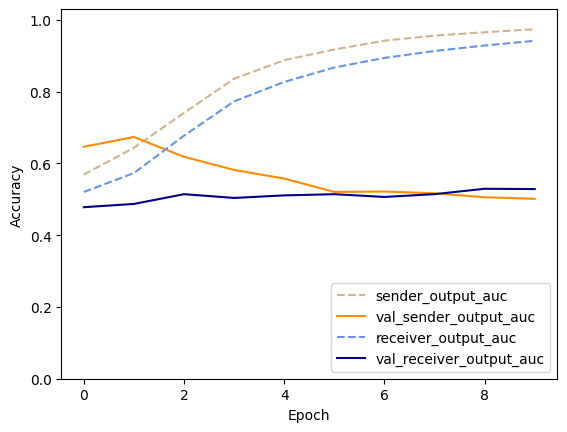

========== Test Evaluation ==========
78/78 - 1s - loss: 0.9891 - sender_output_loss: 0.5971 - receiver_output_loss: 0.3920 - sender_output_auc: 0.5492 - receiver_output_auc_1: 0.5431 - 501ms/epoch - 6ms/step

========== Test Metrics ==========
78/78 [==============================] - 1s 6ms/step
Best Threshold for Sender: 0.22 with F1 Score: 0.5430121349238997
Best Threshold for Receiver: 0.19 with F1 Score: 0.5359235735187902

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.94      0.93      2268
       False       0.17      0.14      0.16       207

    accuracy                           0.87      2475
   macro avg       0.55      0.54      0.54      2475
weighted avg       0.86      0.87      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.94      0.94      2310
       False       0.14      0.13      0.13       165

  

In [103]:
EvaluateModel(naive_lstm_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_lstm_history);

<hr/>

# Context lstm

In [104]:
def create_context_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_lstm_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_lstm_ouput)

    context_lstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_lstm_model

In [105]:
context_lstm_model = create_context_lstm_model()
context_lstm_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_22 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

In [106]:
context_lstm_history = context_lstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 57s 135ms/step - loss: 0.4686 - sender_output_loss: 0.2307 - receiver_output_loss: 0.2379 - sender_output_auc: 0.5569 - receiver_output_auc_1: 0.5312 - val_loss: 0.3281 - val_sender_output_loss: 0.1630 - val_receiver_output_loss: 0.1651 - val_sender_output_auc: 0.6197 - val_receiver_output_auc_1: 0.4367
Epoch 2/10
376/376 [==============================] - 41s 108ms/step - loss: 0.3745 - sender_output_loss: 0.1830 - receiver_output_loss: 0.1915 - sender_output_auc: 0.5834 - receiver_output_auc_1: 0.5131 - val_loss: 0.3201 - val_sender_output_loss: 0.1609 - val_receiver_output_loss: 0.1592 - val_sender_output_auc: 0.6386 - val_receiver_output_auc_1: 0.4488
Epoch 3/10
376/376 [==============================] - 39s 104ms/step - loss: 0.3744 - sender_output_loss: 0.1827 - receiver_output_loss: 0.1917 - sender_output_auc: 0.5855 - receiver_output_auc_1: 0.5065 - val_loss: 0.3194 - val_sender_output_loss: 0.1609 - val_receiver_output_loss

========== Model Accuracy ==========


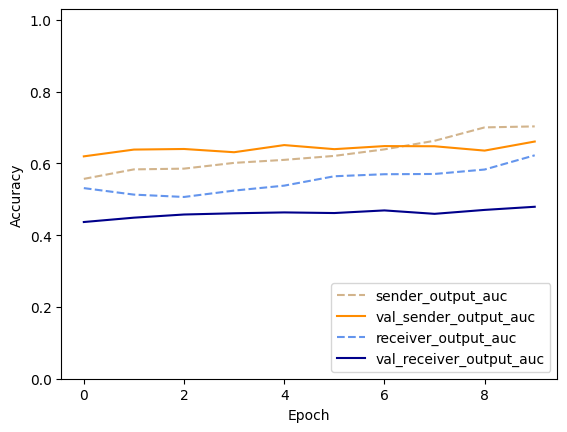

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5166 - sender_output_loss: 0.2780 - receiver_output_loss: 0.2386 - sender_output_auc: 0.6611 - receiver_output_auc_1: 0.6540 - 3s/epoch - 36ms/step

========== Test Metrics ==========
78/78 [==============================] - 3s 34ms/step
Best Threshold for Sender: 0.11 with F1 Score: 0.5725779136565604
Best Threshold for Receiver: 0.08 with F1 Score: 0.5657367732266677

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.94      0.93      2268
       False       0.22      0.20      0.21       207

    accuracy                           0.87      2475
   macro avg       0.58      0.57      0.57      2475
weighted avg       0.87      0.87      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.94      0.94      2310
       False       0.19      0.19      0.19       165

   

In [107]:
sender_threshold, receiver_threshold = EvaluateModel(context_lstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_history)

# LSTM + Power

In [108]:
def create_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    lstm_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    lstm_power_ouput = pipe(
        [
            lstm_output,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(lstm_power_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(lstm_power_ouput)

    lstm_power_model = keras.Model(
        inputs=[message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    lstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return lstm_power_model

In [109]:
lstm_power_model = create_lstm_power_model()
lstm_power_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 embedding_24 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                             
                                                                                                  
 lstm_23 (LSTM)              (None, 1024)                 4706304   ['embedding_24[0][0]']        
                                                                                           

In [110]:
lstm_power_history = context_lstm_model.fit(
    [train_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 24s 57ms/step - loss: 0.3608 - sender_output_loss: 0.1720 - receiver_output_loss: 0.1888 - sender_output_auc: 0.6982 - receiver_output_auc_1: 0.6322 - val_loss: 0.3261 - val_sender_output_loss: 0.1645 - val_receiver_output_loss: 0.1616 - val_sender_output_auc: 0.6119 - val_receiver_output_auc_1: 0.4842
Epoch 2/10
376/376 [==============================] - 20s 53ms/step - loss: 0.3566 - sender_output_loss: 0.1689 - receiver_output_loss: 0.1877 - sender_output_auc: 0.7268 - receiver_output_auc_1: 0.6313 - val_loss: 0.3227 - val_sender_output_loss: 0.1635 - val_receiver_output_loss: 0.1592 - val_sender_output_auc: 0.5678 - val_receiver_output_auc_1: 0.5182
Epoch 3/10
376/376 [==============================] - 20s 53ms/step - loss: 0.3486 - sender_output_loss: 0.1674 - receiver_output_loss: 0.1812 - sender_output_auc: 0.7899 - receiver_output_auc_1: 0.6926 - val_loss: 0.3256 - val_sender_output_loss: 0.1617 - val_receiver_output_loss: 0

========== Model Accuracy ==========


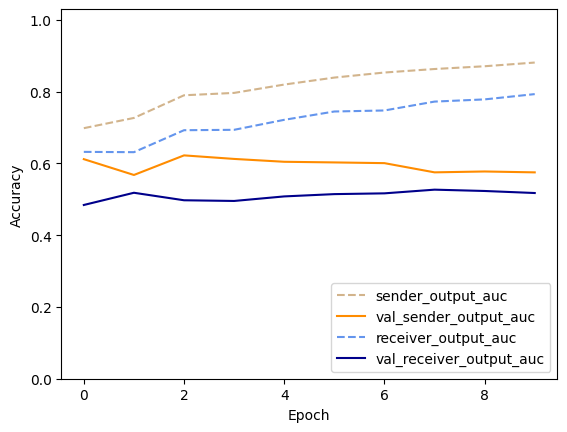

========== Test Evaluation ==========
78/78 - 3s - loss: 1.4159 - sender_output_loss: 0.6935 - receiver_output_loss: 0.7224 - sender_output_auc: 0.4744 - receiver_output_auc_1: 0.5526 - 3s/epoch - 34ms/step

========== Test Metrics ==========
78/78 [==============================] - 2s 18ms/step
Best Threshold for Sender: 0.51 with F1 Score: 0.4781783681214421
Best Threshold for Receiver: 0.7000000000000001 with F1 Score: 0.5139789454910775

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      1.00      0.96      2268
       False       0.00      0.00      0.00       207

    accuracy                           0.92      2475
   macro avg       0.46      0.50      0.48      2475
weighted avg       0.84      0.92      0.88      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.98      0.96      2310
       False       0.14      0.05      0.07 

In [111]:
EvaluateModel(lstm_power_model, [test_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], lstm_power_history);

# Context LSTM + Power

In [112]:
def create_context_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_power_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_lstm_power_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_lstm_power_ouput)

    context_lstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_lstm_power_model

In [113]:
context_lstm_power_model = create_context_lstm_power_model()
context_lstm_power_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_25 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

In [114]:
context_lstm_power_history = context_lstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 55s 136ms/step - loss: 0.4728 - sender_output_loss: 0.2330 - receiver_output_loss: 0.2398 - sender_output_auc: 0.5624 - receiver_output_auc_1: 0.5215 - val_loss: 0.3210 - val_sender_output_loss: 0.1617 - val_receiver_output_loss: 0.1592 - val_sender_output_auc: 0.6188 - val_receiver_output_auc_1: 0.4991
Epoch 2/10
376/376 [==============================] - 40s 107ms/step - loss: 0.3736 - sender_output_loss: 0.1818 - receiver_output_loss: 0.1917 - sender_output_auc: 0.6007 - receiver_output_auc_1: 0.5276 - val_loss: 0.3205 - val_sender_output_loss: 0.1619 - val_receiver_output_loss: 0.1586 - val_sender_output_auc: 0.6358 - val_receiver_output_auc_1: 0.5044
Epoch 3/10
376/376 [==============================] - 39s 103ms/step - loss: 0.3707 - sender_output_loss: 0.1804 - receiver_output_loss: 0.1902 - sender_output_auc: 0.6179 - receiver_output_auc_1: 0.5439 - val_loss: 0.3243 - val_sender_output_loss: 0.1644 - val_receiver_output_loss

========== Model Accuracy ==========


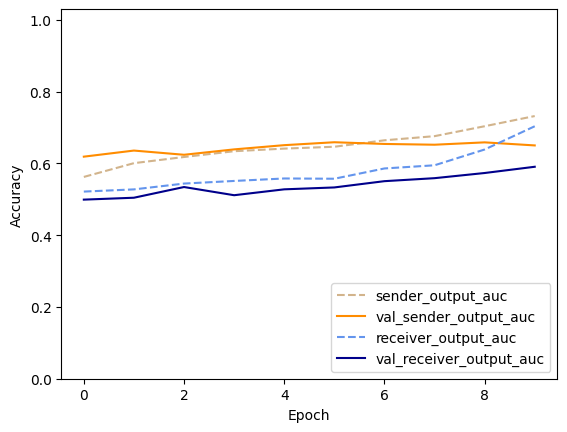

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5853 - sender_output_loss: 0.3126 - receiver_output_loss: 0.2726 - sender_output_auc: 0.6428 - receiver_output_auc_1: 0.5991 - 3s/epoch - 36ms/step

========== Test Metrics ==========
78/78 [==============================] - 3s 34ms/step
Best Threshold for Sender: 0.06 with F1 Score: 0.5596582438373839
Best Threshold for Receiver: 0.06 with F1 Score: 0.5435578572371026

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.91      0.92      2268
       False       0.18      0.22      0.20       207

    accuracy                           0.85      2475
   macro avg       0.56      0.56      0.56      2475
weighted avg       0.87      0.85      0.86      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.96      0.95      2310
       False       0.17      0.12      0.14       165

   

In [115]:
EvaluateModel(context_lstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_power_history);

<hr/>

# Context LSTM Prediction Analysis

In [116]:
pred = context_lstm_model.predict([test_encoded_padded, test_prev_encoded_padded])
sender_pred = (pred[0] > sender_threshold).astype(int).reshape(-1)
receiver_pred = (pred[1] > receiver_threshold).astype(int).reshape(-1)

display(sender_pred)
display(receiver_pred)

78/78 [==============================] - 3s 33ms/step


array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

## Sender Predictions

In [117]:
sender_table = PredictionGridPeek(sender_pred, test_df, CLASS_LABELS, "sender")
sender_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,Russia told me they wouldn’t go. I told them ...,Looks like Italy and A are friends maybe?
2,True,False,"I'd personally rather you didn't, because a pl...","Bongiorno! To crush my enemies, see them driv..."
3,False,True,"Oh, gdi. Now I have to tell a truth that soun...","Thanks, let's have a good game!"


In [118]:
sender_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

'Russia told me they wouldn’t go.  I told them I wouldn’t go, but said I’d cover my ass.  Looks like I told they truth and they didn’t, but it’s not irreparable, at present.'

"I'd personally rather you didn't, because a play around Munich is also a play around Trieste and Vienna. I've heard that there's some rancor over in the West and you might be able to profit from a mobbed France if you went that way."

"Oh, gdi.  Now I have to tell a truth that sounds like the most cliched lie in the game: my order update didn't take, I wasn't intending to go to Piedmont.  Yes, I know it sounds ridiculous, but in this case true."

In [119]:
sender_table["context"].map(display);

''

'Looks like Italy and A are friends maybe?'

'Bongiorno!  To crush my enemies, see them driven before me, and hear the lamentations of their women!  I mean, umm, not really sure yet.  Pondering whether or not to make an early play around Munich'

"Thanks, let's have a good game!"

## Receiver Predictions

In [120]:
receiver_table = PredictionGridPeek(receiver_pred, test_df, CLASS_LABELS, "receiver")
receiver_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,"You're funny. Why is giving up Sev ""way too da...","OK but I can't give up SEV, not yet anyway. Wa..."
2,True,False,"Well, if you want to attack France in the Medi...","Well....that's a great question, and a lot of ..."
3,False,True,"Well, I got him to go to Piedmont, which I did...",I have to play some guessing games with Russia...


In [121]:
receiver_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

'You\'re funny. Why is giving up Sev "way too dangerous? It\'s not like me having it gives me access to very much of your territory... it is Russian territory after all. You are already a very powerful country, and if you do as I suggest, moving into Gre and Serbia, you could have nine supply centers. If you give me Sev, I will support you into Bud'

'Well, if you want to attack France in the Mediterranean while I attack through Burgundy you can have Marseille and Iberia while I take Brest and Paris, then with France out of the way you could focus on Turkey or Austria. Sound fair?'

"Well, I got him to go to Piedmont, which I didn't expect to work, and having bounced Russia out of Galicia, none of my centers are under threat, so even if Italy gets cute, I'm covering Trieste."

In [122]:
receiver_table["context"].map(display);

''

"OK but I can't give up SEV, not yet anyway. Way too dangerous. Move into GAL and I'll support you into BUD in the fall"

"Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?"

'I have to play some guessing games with Russia - I covered my butt with Arm, but I was hoping I wouldn’t lose Bla.  But you and I are good, and I’m in position to go “mostly fleets” and you my army-heavy ally.  What do you think about Italy?'

# Context GRU



In [123]:
def create_context_gru_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        gru_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and GRU layers
    current_message_gru = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.GRU(gru_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_gru = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.GRU(gru_size),
        keras.layers.Dropout(dropout)
    )

    # Concatenate GRU outputs
    context_gru_output = pipe(
        [
            current_message_gru,
            previous_message_gru
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_gru_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_gru_output)

    # Model
    context_gru_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_gru_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_gru_model


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_27 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

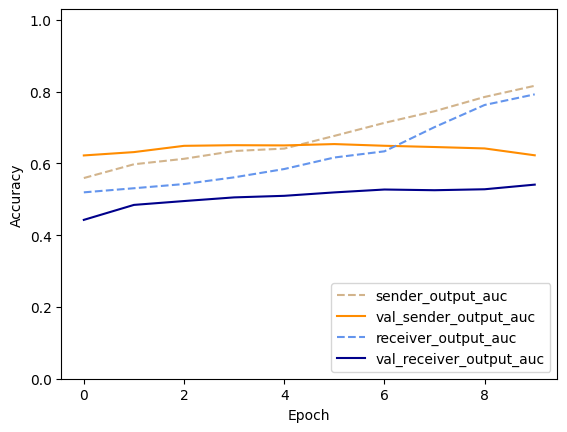

========== Test Evaluation ==========
78/78 - 2s - loss: 0.5422 - sender_output_loss: 0.2955 - receiver_output_loss: 0.2467 - sender_output_auc: 0.6117 - receiver_output_auc_1: 0.6034 - 2s/epoch - 31ms/step

========== Test Metrics ==========
78/78 [==============================] - 3s 29ms/step
Best Threshold for Sender: 0.13 with F1 Score: 0.5645868166388002
Best Threshold for Receiver: 0.09 with F1 Score: 0.54042452213631

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.97      0.95      2268
       False       0.28      0.14      0.18       207

    accuracy                           0.90      2475
   macro avg       0.60      0.55      0.56      2475
weighted avg       0.87      0.90      0.88      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.92      0.93      2310
       False       0.13      0.18      0.15       165

    a

In [124]:
context_gru_model = create_context_gru_model()
context_gru_model.summary()

context_gru_history = context_gru_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_gru_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_gru_history)


# Bi-Directional Context LSTM

In [125]:
def create_context_bilstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.2,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and Bi-LSTM layers
    current_message_bilstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bilstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-LSTM outputs
    context_bilstm_output = pipe(
        [
            current_message_bilstm,
            previous_message_bilstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    # Model
    context_bilstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_29 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

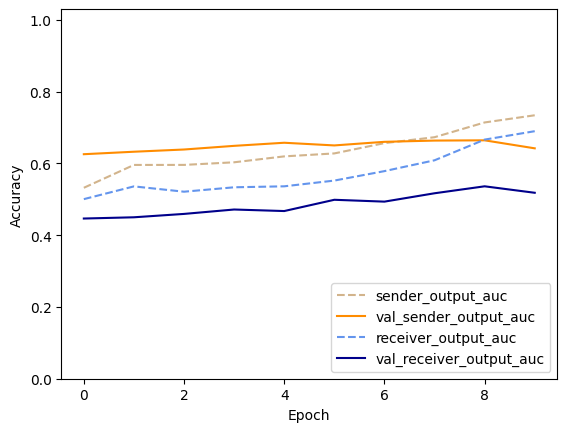

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5376 - sender_output_loss: 0.2959 - receiver_output_loss: 0.2417 - sender_output_auc: 0.6470 - receiver_output_auc_1: 0.6123 - 5s/epoch - 68ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 66ms/step
Best Threshold for Sender: 0.07 with F1 Score: 0.5664907739280499
Best Threshold for Receiver: 0.08 with F1 Score: 0.5475745523663489

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.90      0.91      2268
       False       0.19      0.26      0.22       207

    accuracy                           0.85      2475
   macro avg       0.56      0.58      0.57      2475
weighted avg       0.87      0.85      0.86      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.92      0.93      2310
       False       0.15      0.18      0.16       165

   

In [126]:
context_bilstm_model = create_context_bilstm_model()
context_bilstm_model.summary()

context_bilstm_history = context_bilstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_history)


# Bi-Directional Context GRU

In [127]:
def create_context_bigru_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        gru_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and Bi-GRU layers
    current_message_bigru = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.GRU(gru_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bigru = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.GRU(gru_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-GRU outputs
    context_bigru_output = pipe(
        [
            current_message_bigru,
            previous_message_bigru
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bigru_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bigru_output)

    # Model
    context_bigru_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bigru_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bigru_model


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_31 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

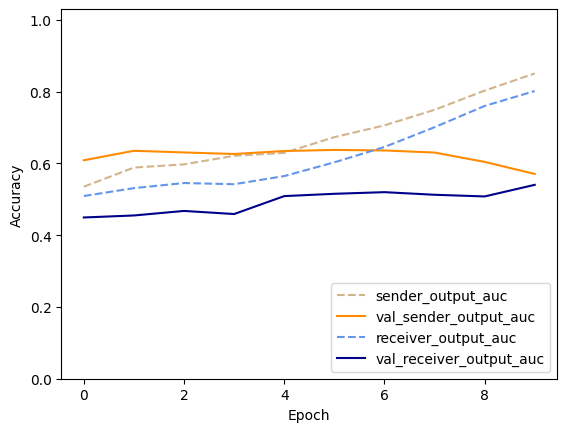

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5631 - sender_output_loss: 0.3074 - receiver_output_loss: 0.2557 - sender_output_auc: 0.5690 - receiver_output_auc_1: 0.5671 - 5s/epoch - 59ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 56ms/step
Best Threshold for Sender: 0.13 with F1 Score: 0.5538327730108552
Best Threshold for Receiver: 0.12 with F1 Score: 0.5391955167600031

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.95      0.94      2268
       False       0.21      0.14      0.17       207

    accuracy                           0.88      2475
   macro avg       0.57      0.55      0.55      2475
weighted avg       0.86      0.88      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.96      0.95      2310
       False       0.16      0.11      0.13       165

   

In [128]:
context_bigru_model = create_context_bigru_model()
context_bigru_model.summary()

context_bigru_history = context_bigru_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bigru_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bigru_history)


# Bi-Directional LSTM with CNN

In [129]:
def create_context_bilstm_cnn_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.2,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
        num_filters: int = 128,  # Number of filters for the convolutional layer
        kernel_size: int = 5,    # Kernel size for the convolutional layer
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding layer
    embedding = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Apply embedding layer to inputs
    current_embed = embedding(current_message_input)
    previous_embed = embedding(previous_message_input)

    # CNN layers
    current_cnn = keras.layers.Conv1D(num_filters, kernel_size, activation='relu')(current_embed)
    current_cnn = keras.layers.MaxPooling1D()(current_cnn)

    previous_cnn = keras.layers.Conv1D(num_filters, kernel_size, activation='relu')(previous_embed)
    previous_cnn = keras.layers.MaxPooling1D()(previous_cnn)

    # Bi-LSTM layers
    current_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(current_cnn)
    current_bilstm = keras.layers.Dropout(dropout)(current_bilstm)

    previous_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(previous_cnn)
    previous_bilstm = keras.layers.Dropout(dropout)(previous_bilstm)

    # Concatenate Bi-LSTM outputs
    context_bilstm_output = keras.layers.Concatenate()([current_bilstm, previous_bilstm])
    context_bilstm_output = keras.layers.Dense(hidden_size)(context_bilstm_output)

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    # Model
    context_bilstm_cnn_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_cnn_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_cnn_model


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_33 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inp

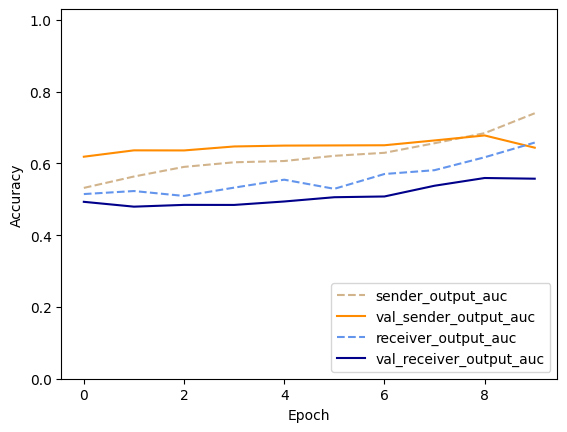

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5191 - sender_output_loss: 0.2791 - receiver_output_loss: 0.2401 - sender_output_auc: 0.6541 - receiver_output_auc_1: 0.6132 - 3s/epoch - 37ms/step

========== Test Metrics ==========
78/78 [==============================] - 4s 35ms/step
Best Threshold for Sender: 0.12 with F1 Score: 0.578353391912714
Best Threshold for Receiver: 0.09 with F1 Score: 0.5392380108799598

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.93      0.93      2268
       False       0.23      0.22      0.23       207

    accuracy                           0.87      2475
   macro avg       0.58      0.58      0.58      2475
weighted avg       0.87      0.87      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.89      0.92      2310
       False       0.13      0.22      0.16       165

    

In [130]:
context_bilstm_cnn_model = create_context_bilstm_cnn_model()
context_bilstm_cnn_model.summary()

context_bilstm_cnn_history = context_bilstm_cnn_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_cnn_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_cnn_history)


In [131]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

In [132]:
from tokenizers import ByteLevelBPETokenizer

# Initialize a tokenizer
bpe_tokenizer = ByteLevelBPETokenizer()

# Get a list of all messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Train the tokenizer
bpe_tokenizer.train_from_iterator(all_messages, vocab_size=VOCAB_SIZE)

def bpe_tokenize_and_pad(tokenizer, df, max_length):
    input_ids = []

    for sent in df['messages']:
        encoded = tokenizer.encode(sent)
        # Padding and truncating
        padding_length = max_length - len(encoded.ids)
        ids = encoded.ids + [0] * padding_length if padding_length > 0 else encoded.ids[:max_length]
        input_ids.append(ids)

    return tf.convert_to_tensor(input_ids)

train_encoded_padded = bpe_tokenize_and_pad(bpe_tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded = bpe_tokenize_and_pad(bpe_tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded = bpe_tokenize_and_pad(bpe_tokenizer, validation_df, MAX_SEQUENCE_LEN)


In [133]:
def create_context_bilstm_model_bpe(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.1,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input_bpe = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input_bpe = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and Bi-LSTM layers
    current_message_bilstm_bpe = pipe(
        current_message_input_bpe,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bilstm_bpe = pipe(
        previous_message_input_bpe,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-LSTM outputs
    context_bilstm_output = pipe(
        [
            current_message_bilstm_bpe,
            previous_message_bilstm_bpe
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    # Model
    context_bilstm_model_bpe = keras.Model(
        inputs=[current_message_input_bpe, previous_message_input_bpe],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_model_bpe.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model_bpe


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_34 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

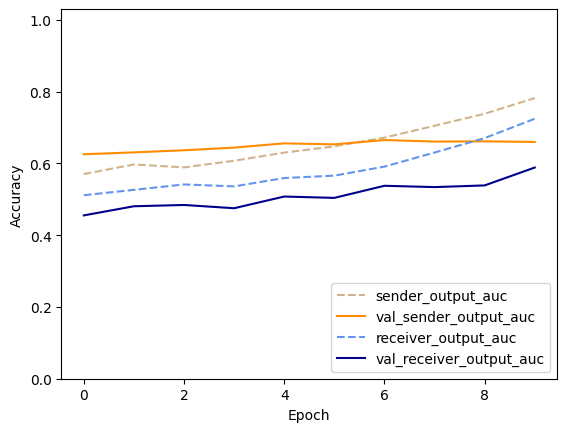

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5615 - sender_output_loss: 0.3093 - receiver_output_loss: 0.2521 - sender_output_auc: 0.6558 - receiver_output_auc_1: 0.5936 - 5s/epoch - 68ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 65ms/step
Best Threshold for Sender: 0.09 with F1 Score: 0.5755516051448291
Best Threshold for Receiver: 0.08 with F1 Score: 0.5344892824662608

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.95      0.94      2268
       False       0.25      0.19      0.21       207

    accuracy                           0.88      2475
   macro avg       0.59      0.57      0.58      2475
weighted avg       0.87      0.88      0.88      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.95      0.95      2310
       False       0.14      0.11      0.12       165

   

In [134]:
context_bilstm_model_bpe = create_context_bilstm_model_bpe()
context_bilstm_model_bpe.summary()

context_bilstm_history_bpe = context_bilstm_model_bpe.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_model_bpe, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_history_bpe)


# Bi-LSTM with SpaCy linguistic features

In [135]:
# Load SpaCy model
import spacy
nlp = spacy.load('en_core_web_sm')

def extract_features(text):
    doc = nlp(text)
    features = {
        "pos_tags": [token.pos_ for token in doc],
        "ner_tags": [ent.label_ for ent in doc.ents],
        # Add more features as needed
    }
    return features


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_36 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inp

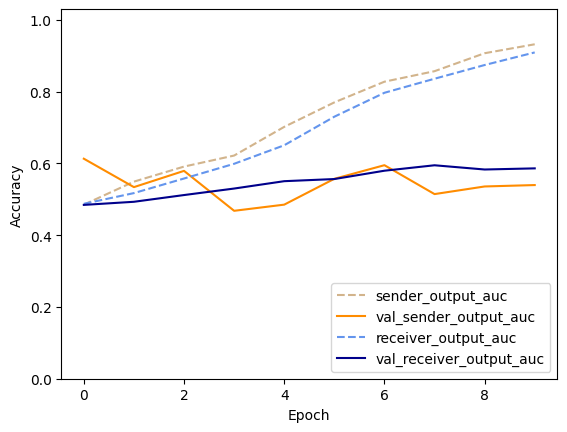

========== Test Evaluation ==========
78/78 - 5s - loss: 0.8602 - sender_output_loss: 0.4957 - receiver_output_loss: 0.3645 - sender_output_auc: 0.5381 - receiver_output_auc_1: 0.5209 - 5s/epoch - 68ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 66ms/step
Best Threshold for Sender: 0.03 with F1 Score: 0.5321189872182651
Best Threshold for Receiver: 0.14 with F1 Score: 0.5337198490400918

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.88      0.90      2268
       False       0.14      0.20      0.16       207

    accuracy                           0.82      2475
   macro avg       0.53      0.54      0.53      2475
weighted avg       0.86      0.82      0.84      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.96      0.95      2310
       False       0.15      0.10      0.12       165

   

In [136]:
import spacy
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

# Load SpaCy model for English
nlp = spacy.load("en_core_web_sm")

def extract_pos_tags(texts, max_len):
    pos_tags = []
    for doc in nlp.pipe(texts):
        tags = [token.pos_ for token in doc]
        pos_tags.append(tags)
    pos_tag_index = {tag: i + 1 for i, tag in enumerate(set(tag for tags in pos_tags for tag in tags))}
    encoded_tags = [[pos_tag_index[tag] for tag in tags] for tags in pos_tags]
    padded_tags = pad_sequences(encoded_tags, maxlen=max_len, padding='post')
    return np.array(padded_tags)

def create_context_bilstm_model_spacy(
        sequence_length,
        embedding_output,
        vocab_size,
        lstm_size,
        dropout,
        hidden_size,
        learning_rate,
        linguistic_feature_size):

    current_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    current_linguistic_input = layers.Input(shape=(linguistic_feature_size,), name='current_linguistic_input')
    previous_linguistic_input = layers.Input(shape=(linguistic_feature_size,), name='previous_linguistic_input')

    embedding = layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)
    current_embed = embedding(current_message_input)
    previous_embed = embedding(previous_message_input)

    def bi_lstm_layer(input_layer):
        return layers.Bidirectional(layers.LSTM(lstm_size))(input_layer)

    current_message_bilstm = bi_lstm_layer(current_embed)
    previous_message_bilstm = bi_lstm_layer(previous_embed)

    current_combined = layers.Concatenate()([current_message_bilstm, current_linguistic_input])
    previous_combined = layers.Concatenate()([previous_message_bilstm, previous_linguistic_input])

    context_bilstm_output = layers.Concatenate()([current_combined, previous_combined])
    context_bilstm_output = layers.Dense(hidden_size)(context_bilstm_output)

    sender_output = layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    context_bilstm_model_spacy = models.Model(
        inputs=[current_message_input, previous_message_input, current_linguistic_input, previous_linguistic_input],
        outputs=[sender_output, receiver_output]
    )

    context_bilstm_model_spacy.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model_spacy

# Extract POS tags from datasets
train_pos_tags = extract_pos_tags(train_df['messages'], MAX_SEQUENCE_LEN)
test_pos_tags = extract_pos_tags(test_df['messages'], MAX_SEQUENCE_LEN)
validation_pos_tags = extract_pos_tags(validation_df['messages'], MAX_SEQUENCE_LEN)

# Create and compile the model
context_bilstm_model_spacy = create_context_bilstm_model_spacy(
    sequence_length=294,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.25,
    hidden_size=1000,
    learning_rate=3e-5,
    linguistic_feature_size=train_pos_tags.shape[1]
)

# Model summary
context_bilstm_model_spacy.summary()

# Train the model
context_bilstm_history_spacy = context_bilstm_model_spacy.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_pos_tags, train_pos_tags],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_pos_tags, validation_pos_tags],
                     [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

# Assuming EvaluateModel is a custom function that you have defined for model evaluation
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_model_spacy,
    [test_encoded_padded, test_prev_encoded_padded, test_pos_tags, test_pos_tags],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_history_spacy
)


In [137]:
train_df

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
7,"Sorry Italy I've been away doing, um, German t...",True,True,germany,italy,117,7,Spring,1901,3,0.0,1,0,Any thoughts?,straightforward,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,Is there any way of me actually ending this co...,True,True,france,england,380,11,Fall,1902,4,-1.0,10,187,I guess we will see what happens,straightforward,0,0
13128,Can we agree on peace? What are your demands?,True,True,france,england,433,12,Fall,1902,4,-1.0,10,187,Is there any way of me actually ending this co...,straightforward,0,0
13129,"Neutrality in exchange for current holdings, S...",True,False,england,france,434,13,Fall,1902,5,1.0,10,187,Can we agree on peace? What are your demands?,cassandra,0,1
13130,"Thats a bit too much, can I keep Spain and i h...",True,True,france,england,437,14,Fall,1902,4,-1.0,10,187,"Neutrality in exchange for current holdings, S...",straightforward,0,0


# Bi-Directional Context LSTM with Power

In [138]:
def create_context_bilstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.15,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 3e-5,
    ):

    # Input layers
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    # Embedding layer
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Apply embedding and Bi-LSTM to current and previous messages
    current_message_embedded = embedding_layer(current_message_input)
    previous_message_embedded = embedding_layer(previous_message_input)

    current_message_bilstm = pipe(
        current_message_embedded,
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bilstm = pipe(
        previous_message_embedded,
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-LSTM outputs with power differential input
    context_bilstm_power_output = keras.layers.Concatenate()(
        [current_message_bilstm, previous_message_bilstm, power_diff_input]
    )

    # Dense layer and outputs
    context_bilstm_power_output = keras.layers.Dense(hidden_size)(context_bilstm_power_output)
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_power_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_power_output)

    # Model creation
    context_bilstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile the model
    context_bilstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_power_model

In [139]:
train_encoded_padded

<tf.Tensor: shape=(12025, 294), dtype=int32, numpy=
array([[1443,    0,  198, ...,    0,    0,    0],
       [ 499,  645,  333, ...,    0,    0,    0],
       [3551,    0,    0, ...,    0,    0,    0],
       ...,
       [  45,   68, 1817, ...,    0,    0,    0],
       [ 716,   82,  257, ...,    0,    0,    0],
       [1220,  934,   82, ...,    0,    0,    0]], dtype=int32)>

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_37 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inp

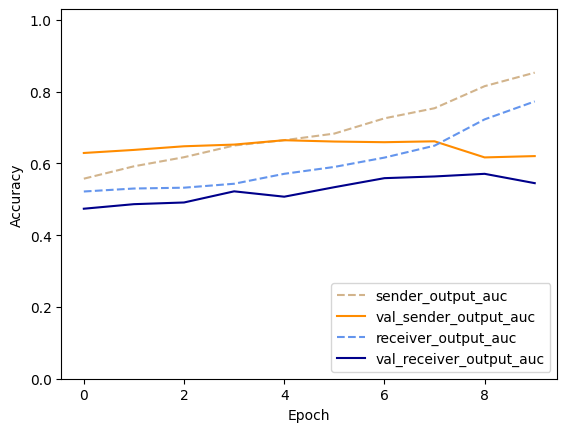

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5691 - sender_output_loss: 0.3103 - receiver_output_loss: 0.2589 - sender_output_auc: 0.6348 - receiver_output_auc_1: 0.5966 - 5s/epoch - 68ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 65ms/step
Best Threshold for Sender: 0.18 with F1 Score: 0.5770544281935016
Best Threshold for Receiver: 0.08 with F1 Score: 0.549299197088217

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.96      0.94      2268
       False       0.28      0.17      0.21       207

    accuracy                           0.89      2475
   macro avg       0.60      0.56      0.58      2475
weighted avg       0.87      0.89      0.88      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.92      0.93      2310
       False       0.15      0.19      0.17       165

    

In [140]:
# Reshape 'game_score_delta' to have an additional dimension
train_power_diff = train_df['game_score_delta']
test_power_diff = test_df['game_score_delta']
validation_power_diff = validation_df['game_score_delta']

context_bilstm_power_model = create_context_bilstm_power_model()
context_bilstm_power_model.summary()

# Training the model
context_bilstm_power_history = context_bilstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_power_diff],  # Including reshaped power differential input
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded, validation_prev_encoded_padded, validation_power_diff],  # Including reshaped power differential input
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_power_diff], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_power_history)

In [141]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [142]:

from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow import keras
from toolz import pipe

MAX_SEQUENCE_LEN = 294
EMBEDDING_OUTPUT_SIZE = 768  # Typically BERT's embedding size
VOCAB_SIZE = 30522  # For BERT base model
DROPOUT_RATE = 0.1
HIDDEN_LAYER_SIZE = 256

def create_context_bert_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    bert_base_model = bert_model

    # Define inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int32, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int32, name='previous_message_input')

    # BERT embeddings
    current_message_bert = bert_base_model(current_message_input)[1]
    previous_message_bert = bert_base_model(previous_message_input)[1]

    # Dropout
    current_message_dropout = keras.layers.Dropout(dropout)(current_message_bert)
    previous_message_dropout = keras.layers.Dropout(dropout)(previous_message_bert)

    # Concatenate embeddings
    context_bert_output = keras.layers.Concatenate()([current_message_dropout, previous_message_dropout])
    context_bert_output = keras.layers.Dense(hidden_size, activation='relu')(context_bert_output)

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bert_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bert_output)

    # Model
    context_bert_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    context_bert_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bert_model

